In [1]:
import datetime as dt

import arviz as az
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import numpyro
import numpyro.distributions as dist
import pandas as pd
import seaborn as sns
from jax import random
from numpyro.handlers import reparam
from numpyro.infer import MCMC, NUTS, Predictive
from numpyro.infer.reparam import LocScaleReparam
from scipy.special import expit, logit
from sklearn.preprocessing import LabelEncoder

assert numpyro.__version__.startswith("0.8.0")


/opt/hostedtoolcache/Python/3.10.1/x64/lib/python3.10/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '
/opt/hostedtoolcache/Python/3.10.1/x64/lib/python3.10/site-packages/jax/experimental/stax.py:28: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  warnings.warn('jax.experimental.stax is deprecated, '


In [2]:
df = pd.read_csv(
    'data/meta_lineages.csv',
    index_col=0,
    parse_dates=[1,3],
    infer_datetime_format=True,
    cache_dates=True,
    dtype = {'SEQ_REASON': 'category',
             'SENDING_LAB_PC': 'category',
             'SEQUENCING_LAB_PC': 'category',
             'lineage': 'category',
             'scorpio_call': 'category'
             }
)
df.rename(columns={
    'DATE_DRAW': 'date',
    'PROCESSING_DATE': 'processing_date',
    'SEQ_REASON': 'reason',
    'SENDING_LAB_PC': 'sending_pc',
    'SEQUENCING_LAB_PC': 'sequencing_pc',
    'lineage': 'lineage',
    'scorpio_call': 'scorpio'
    },
    inplace=True
)

In [3]:
df = df[df.date > '2021-11-01']
df = df[df.reason.isin(['N'])]
df['omi'] = df.lineage.apply(lambda x: int((x == 'BA.1')))
all = df.groupby(['sending_pc','date'])['omi'].count()
omi = df.groupby(['sending_pc','date'])['omi'].apply(lambda x: (x == 1).sum()).fillna(0).astype(int)
df_reshaped = pd.concat({'all': all, 'omi': omi}, axis=1).reset_index()
today = pd.Timestamp(str(dt.date.today()))
df_reshaped['days'] = (df_reshaped.date-today).dt.days
df_reshaped['sending_area'] = df_reshaped.sending_pc.apply(lambda x: int(x[0]))
lab_counts = df_reshaped[df_reshaped.date > '2021-12-01'].groupby('sending_pc')['all'].sum()
# df_filtered = df_reshaped[df_reshaped.sending_pc.isin(lab_counts[lab_counts>10].index) & (~df_reshaped.sending_pc.isin(['22767','70193','24106']))].copy()
df_filtered = df_reshaped[df_reshaped.sending_pc.isin(lab_counts[lab_counts>10].index) & (~df_reshaped.sending_pc.isin(['']))].copy()
le = LabelEncoder()
df_filtered['sending_pc_ID'] = le.fit_transform(df_filtered['sending_pc'].values)
omi_counts = df_filtered["omi"].values
total_counts = df_filtered["all"].values
sample_day = df_filtered["days"].values
sending_pc_ID = df_filtered['sending_pc_ID'].values
sending_area = df_filtered['sending_area'].values

In [4]:
# reparam_config = {"a": LocScaleReparam(0) for k in ["a"]}

# Reparametrization doesn't seem to work with discrete latent variable
# @numpyro.handlers.reparam(config=reparam_config)
def model(sending_pc, sample_day, total_counts,omi_counts=None):
    mu_a = numpyro.sample("mu_a", dist.Normal(0, 5.0))
    sigma_a = numpyro.sample("sigma_a", dist.HalfNormal(3.0))
    b = numpyro.sample("b", dist.Normal(0.2, 0.2))
    outlier_p = numpyro.sample("outlier_p", dist.Beta(1, 20))
    outlier_sigma = numpyro.sample("outlier_sigma", dist.TruncatedNormal(0.1,1,1))

    n_labs = len(np.unique(sending_pc))

    with numpyro.plate("plate_j", n_labs):
        outlier = numpyro.sample("outlier", dist.Bernoulli(outlier_p))

        a = numpyro.sample("a", dist.Normal(mu_a, sigma_a * (1.+outlier_sigma * outlier)))

    logit_est = a[sending_pc] + b * sample_day

    with numpyro.plate("data", len(sending_pc)):
        numpyro.sample("obs", dist.BinomialLogits(logits=logit_est, total_count=total_counts), obs=omi_counts)

In [5]:
nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel, num_samples=5000, num_warmup=2000)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, sending_pc_ID, sample_day, total_counts, omi_counts=omi_counts)

In [6]:
mcmc.print_summary()


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
           a[0]      0.19      0.26      0.20     -0.24      0.61   5161.17      1.00
           a[1]      1.04      0.27      1.05      0.56      1.46   5030.36      1.00
           a[2]     -1.10      2.11     -0.52     -4.10      1.42   1811.48      1.00
           a[3]      2.33      0.31      2.32      1.84      2.86   6089.68      1.00
           a[4]     -0.62      1.90     -0.13     -3.13      1.86   1474.51      1.00
           a[5]      0.49      0.47      0.53     -0.21      1.26   4595.76      1.00
           a[6]      1.45      0.66      1.51      0.42      2.53   4736.01      1.00
           a[7]      2.84      0.31      2.84      2.32      3.33   5770.87      1.00
           a[8]      4.38      0.38      4.38      3.78      5.01   4464.13      1.00
           a[9]      3.74      0.09      3.74      3.59      3.88   1469.61      1.00
          a[10]      0.03      1.80      0.44     -2.

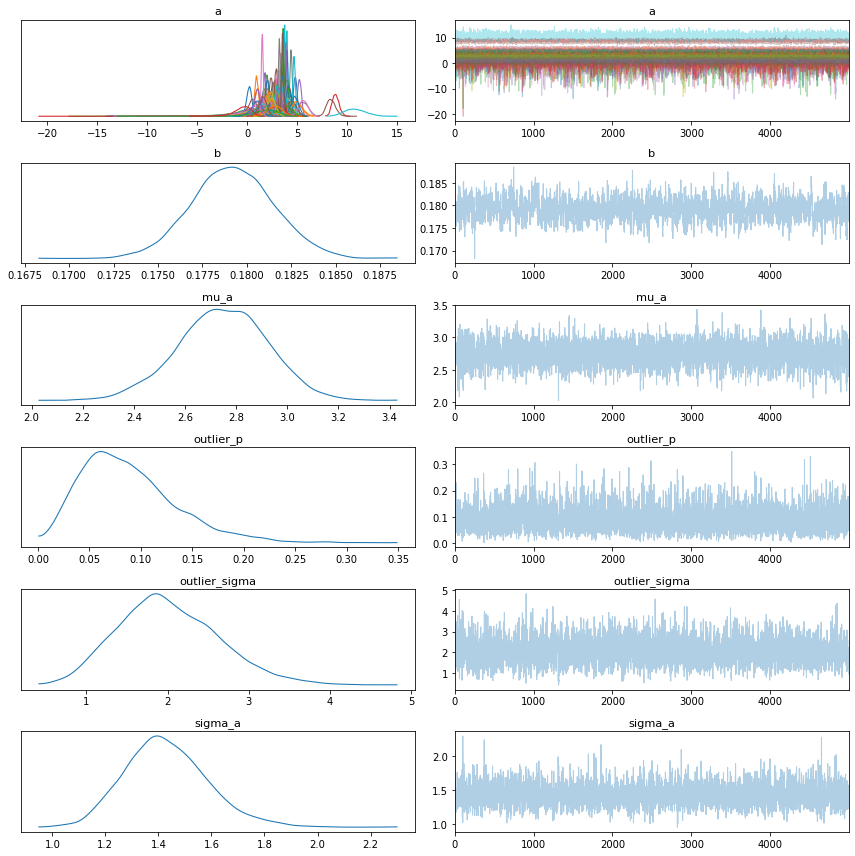

In [7]:
posterior_samples = mcmc.get_samples()
predictive = Predictive(model, posterior_samples, infer_discrete=True)
discrete_samples = predictive(random.PRNGKey(1),sending_pc_ID, sample_day, total_counts, omi_counts=omi_counts)
posterior_samples["outlier"] = discrete_samples["outlier"]
inference_data = az.from_numpyro(
    posterior=mcmc,
    posterior_predictive=discrete_samples,
)
data = az.from_numpyro(mcmc)
az.plot_trace(data,compact=True)
plt.tight_layout()

In [8]:
summary = numpyro.diagnostics.summary(posterior_samples,group_by_chain=False)

In [9]:
pdf = pd.DataFrame(summary['a'])
pdf['outlier_p'] = summary['outlier']['mean']
pdf['plz'] = le.inverse_transform(pdf.index.values)
pdf.set_index('plz',inplace=True)
pdf.sort_values(by='outlier_p',inplace=True)
pdf

,mean,std,median,5.0%,95.0%,n_eff,r_hat,outlier_p
plz,,,,,,,,
32545,2.724428,0.320227,2.733882,2.198397,3.245669,5902.646551,1.000022,0.0296
04289,2.843036,0.305635,2.840125,2.318985,3.325125,5770.869939,0.999800,0.0302
60437,2.223716,0.320470,2.225408,1.713826,2.749333,5225.075270,0.999805,0.0306
66386,2.893188,0.159096,2.895726,2.630952,3.154311,3512.751024,1.000658,0.0308
01458,2.325746,0.314616,2.323790,1.844874,2.863789,6089.679765,0.999884,0.0316
...,...,...,...,...,...,...,...,...
01662,-0.620139,1.895169,-0.125324,-3.133198,1.863818,1474.509659,1.000745,0.3220
01307,-1.103117,2.110698,-0.516111,-4.103858,1.423622,1811.483891,0.999804,0.3994
24106,8.375591,0.450279,8.349636,7.688712,9.135035,4157.423744,1.000177,0.8906


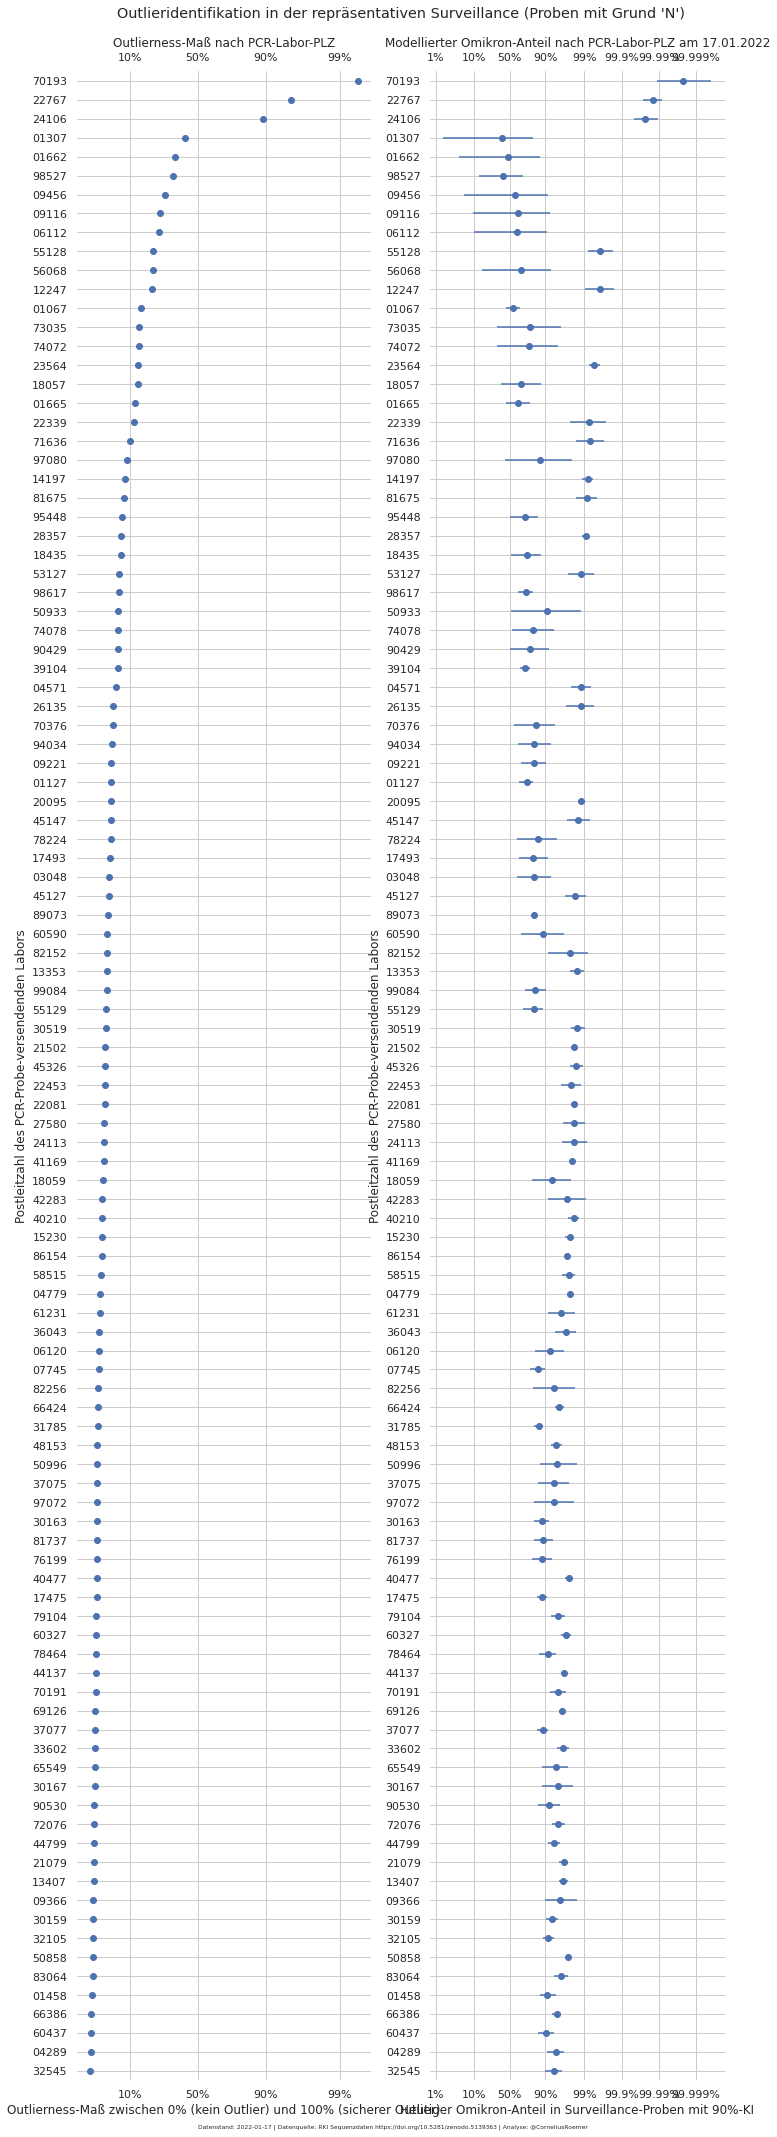

In [10]:
nice_formatter = ticker.FuncFormatter(
    lambda y, _: f'{ np.format_float_positional(100*y, trim="-", precision=6).rstrip(".")}%'
)
sns.set_theme(style="whitegrid")
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,30))

ax1.scatter(pdf['outlier_p'].values,pdf.index.values,linestyle='None',marker='o')
sns.despine(left=True, bottom=True)
ax1.set_ylim(-0.5,len(pdf)-0.5)
ax1.tick_params(axis='both', which='major', labelbottom = True, bottom=False, top = False, labeltop=True)
ax1.tick_params(axis='both', which='minor', labelbottom = False, bottom=False, top = False, labeltop=False)
ax1.set_xscale('logit')
ax1.xaxis.set_major_formatter(nice_formatter)
ax1.set(title=f'Outlierness-Maß nach PCR-Labor-PLZ')
ax1.set_ylabel("Postleitzahl des PCR-Probe-versendenden Labors")
ax1.set_xlabel("Outlierness-Maß zwischen 0% (kein Outlier) und 100% (sicherer Outlier)")


errors = ([expit(pdf['median'])-expit(pdf['5.0%']),expit(pdf['95.0%'])-expit(pdf['median'])])
ax2.errorbar(x=expit(pdf['median'].values),y=pdf.index.values,xerr=errors,linestyle='None',marker='o')
sns.despine(left=True, bottom=True)
ax2.set_ylim(-0.5,len(pdf)-0.5)
ax2.tick_params(axis='both', which='major', labelbottom = True, bottom=False, top = False, labeltop=True)
ax2.tick_params(axis='both', which='minor', labelbottom = False, bottom=False, top = False, labeltop=False)
ax2.set_xscale('logit')
ax2.xaxis.set_major_formatter(nice_formatter)
ax2.set(title=f'Modellierter Omikron-Anteil nach PCR-Labor-PLZ am {today.strftime("%d.%m.%Y")}')
ax2.set_ylabel("Postleitzahl des PCR-Probe-versendenden Labors")
ax2.set_xlabel("Heutiger Omikron-Anteil in Surveillance-Proben mit 90%-KI")

plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.02)
fig.text(0.49, -0.003, f"Datenstand: {str(dt.date.today())} | Datenquelle: RKI Sequenzdaten https://doi.org/10.5281/zenodo.5139363 | Analyse: @CorneliusRoemer", size=6, va="bottom", ha="center")
fig.suptitle("Outlieridentifikation in der repräsentativen Surveillance (Proben mit Grund 'N')")
fig.savefig("plots/omi_outlierness_by_pc.png",dpi=300,bbox_inches='tight',pad_inches=0.2)